In [1]:
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Path to dataset: structured as /dataset/{genre}/*.wav
DATASET_PATH = Path("data/ELECTRONIC_MUSIC_V2")
GENRES = ["Techno", "House", "Trance"]

In [3]:
# Storage
filepaths = []
durations = []
sr_list = []
genre_list = []

# Basic Stats: Duration, Sampling Rate
for genre in GENRES:
    genre_path = DATASET_PATH / genre
    for audio_file in genre_path.glob("*.wav"):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            filepaths.append(audio_file)
            durations.append(duration)
            sr_list.append(sr)
            genre_list.append(genre)
        except Exception as e:
            print(f"Failed to load {audio_file}: {e}")

# Create DataFrame
electronic_tracks_df = pd.DataFrame({
    "filepath": filepaths,
    "genre": genre_list,
    "duration_sec": durations,
    "sampling_rate": sr_list
})

electronic_tracks_df.head()

,filepath,genre,duration_sec,sampling_rate
0,data/ELECTRONIC_MUSIC_V2/Techno/Electronic mus...,Techno,10.0,16000
1,"data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno_...",Techno,10.0,16000
2,"data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno,...",Techno,10.0,16000
3,data/ELECTRONIC_MUSIC_V2/Techno/Electronic mus...,Techno,10.0,16000
4,"data/ELECTRONIC_MUSIC_V2/Techno/Music, Techno_...",Techno,10.0,16000


In [4]:
electronic_tracks_df.iloc[:, 1:].value_counts()

genre   duration_sec  sampling_rate
House   10.0          16000            39
Techno  10.0          16000            29
Trance  10.0          16000            29
Name: count, dtype: int64

In [5]:
FRAME_LENGTH = 4096
HOP_LENGTH = FRAME_LENGTH // 4

FRAME_LENGTH, HOP_LENGTH

(4096, 1024)

Plotting representative example for genre: Techno
data/ELECTRONIC_MUSIC_V2/Techno/Disco, Electronic music, Music, Techno_ULXbXpLcoVA_30.wav


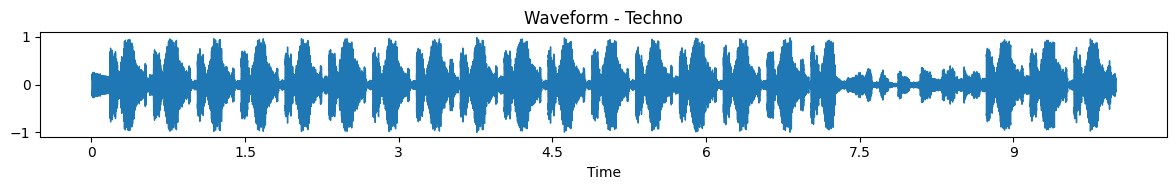

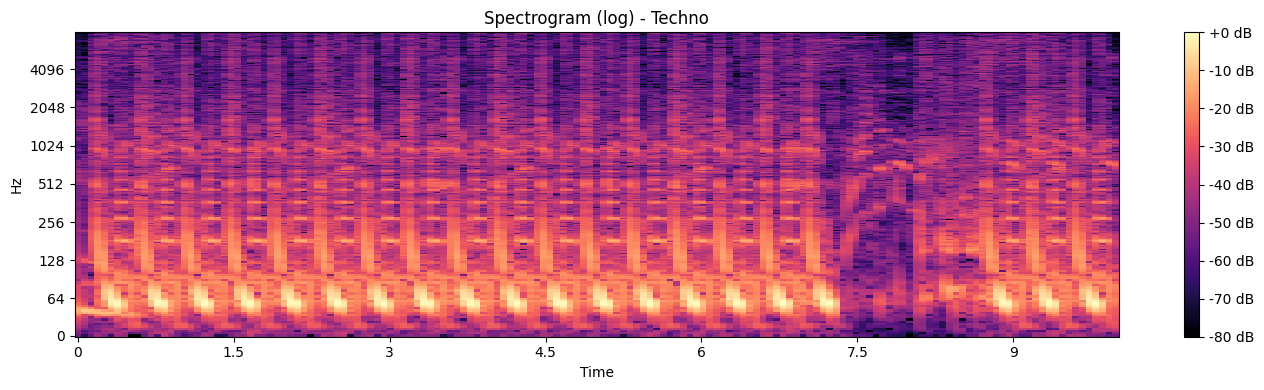

Plotting representative example for genre: House
data/ELECTRONIC_MUSIC_V2/House/Electronic music, House music, Music, Electronica_cFIZraIPAXE_250.wav


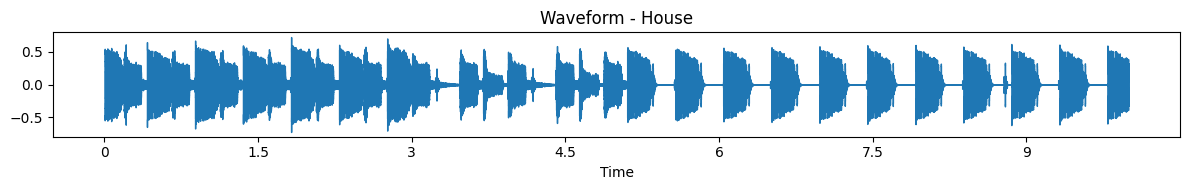

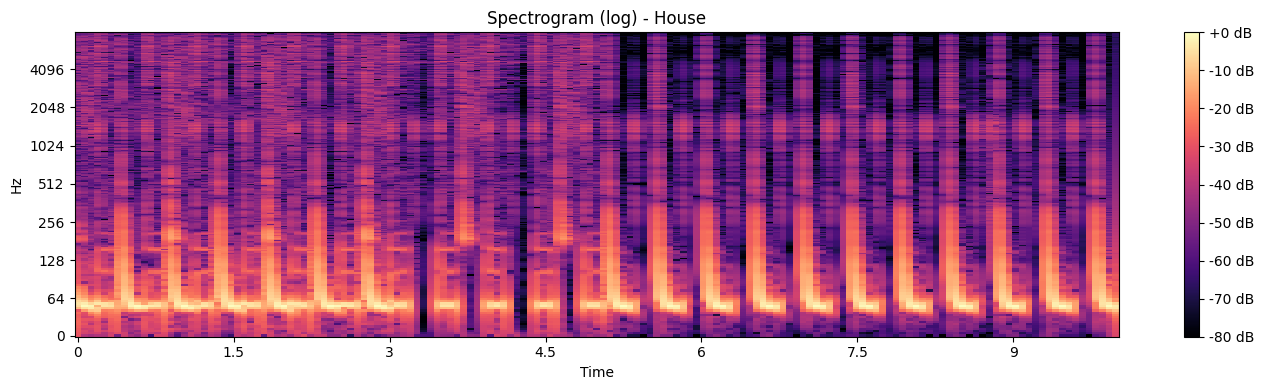

Plotting representative example for genre: Trance
data/ELECTRONIC_MUSIC_V2/Trance/Music, Trance music_M2iDkf1SAWY_0.wav


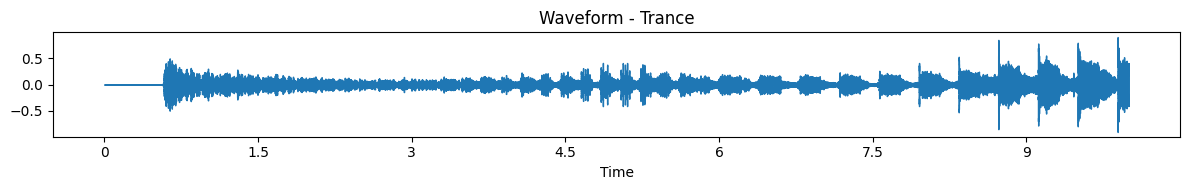

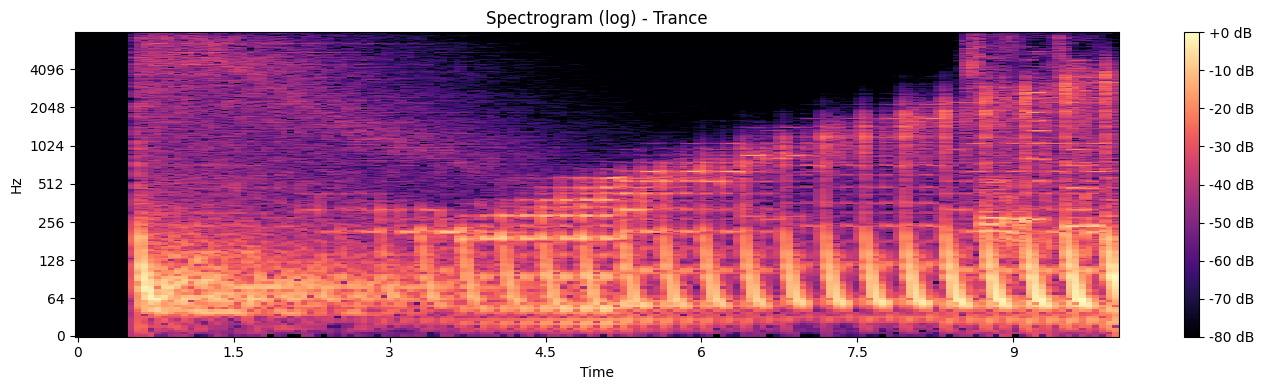

In [6]:
# Mean Waveform & Spectrogram Per Genre
for genre in GENRES:
    print(f"Plotting representative example for genre: {genre}")
    example_path = electronic_tracks_df[electronic_tracks_df["genre"] == genre]["filepath"].sample(1).values[0]
    print(example_path)
    y, sr = librosa.load(example_path, sr=None)

    # Audio sound
    ipd.display(ipd.Audio(y, rate=sr))

    # Waveform
    plt.figure(figsize=(12, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {genre}")
    plt.tight_layout()
    plt.show()

    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)), ref=np.max)
    plt.figure(figsize=(14, 4))
    librosa.display.specshow(D, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram (log) - {genre}")
    plt.tight_layout()
    plt.show()

In [7]:
from utils import extract_features

In [8]:
feature_flags = {
    "zcr": True,
    "centroid": True,
    "onset_strength": True,
    "mfcc": True,
    "chroma": True,
    "spectral_bandwidth": True,
    "spectral_rolloff": True,
    "rms": True,
    "tempogram": False
}

In [9]:
X = []
y = []

for fp, label in zip(electronic_tracks_df["filepath"], electronic_tracks_df["genre"]):
    try:
        audio, sr = librosa.load(fp, sr=None)
        _x = extract_features(filepath=fp, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, segment_duration=5, selected_features=feature_flags)
        
        X.append(_x)
        y.append(label)
        y.append(label)
    except Exception as e:
        print(f"Failed on {fp}: {e}")

X_segments = np.stack(X)  # shape: (samples, time_steps, features)
y_segments = np.array(y)  # shape: (samples,)

X_segments.shape, y_segments.shape

/opt/homebrew/Caskroom/miniconda/base/envs/dmp/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


((97, 2, 79, 31), (194,))

### Treat each segment as an input instance

In [10]:
X = X_segments.reshape(-1, X_segments.shape[2], X_segments.shape[3])
X.shape

(194, 79, 31)

## Data Exploitation

Text(0, 0.5, 'Number of Samples')

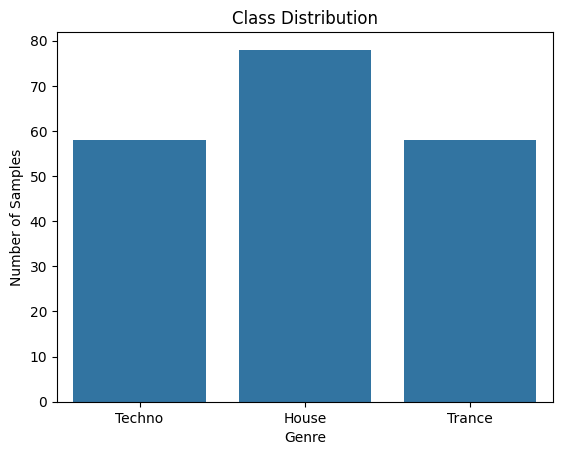

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Genre")
plt.ylabel("Number of Samples")

In [12]:
from utils import get_feature_names

In [13]:
# Flatten X: (n_instances, frames, features) → (n_instances * frames, features)
X_flat_time = X.reshape(-1, X.shape[2])
print(X_flat_time.shape)

# Repeat y values x times each to align with flattened X
y_repeated = np.repeat(y_segments, X.shape[1])

# Define feature names
features_names = get_feature_names(feature_flags=feature_flags)

# Create DataFrame
df_features = pd.DataFrame(X_flat_time, columns=features_names)
df_features['label'] = y_repeated

(15326, 31)


### Correlation matrix after aggregating temporal dimension

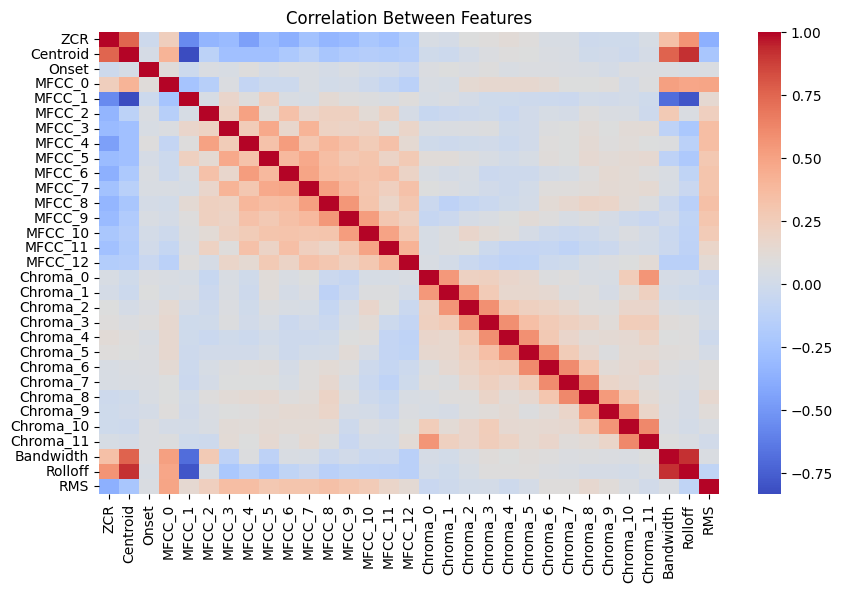

In [14]:
# Check correlation across all samples
corr = df_features.drop(columns=['label']).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Between Features")
plt.show()

### Violin Plots per class/genre

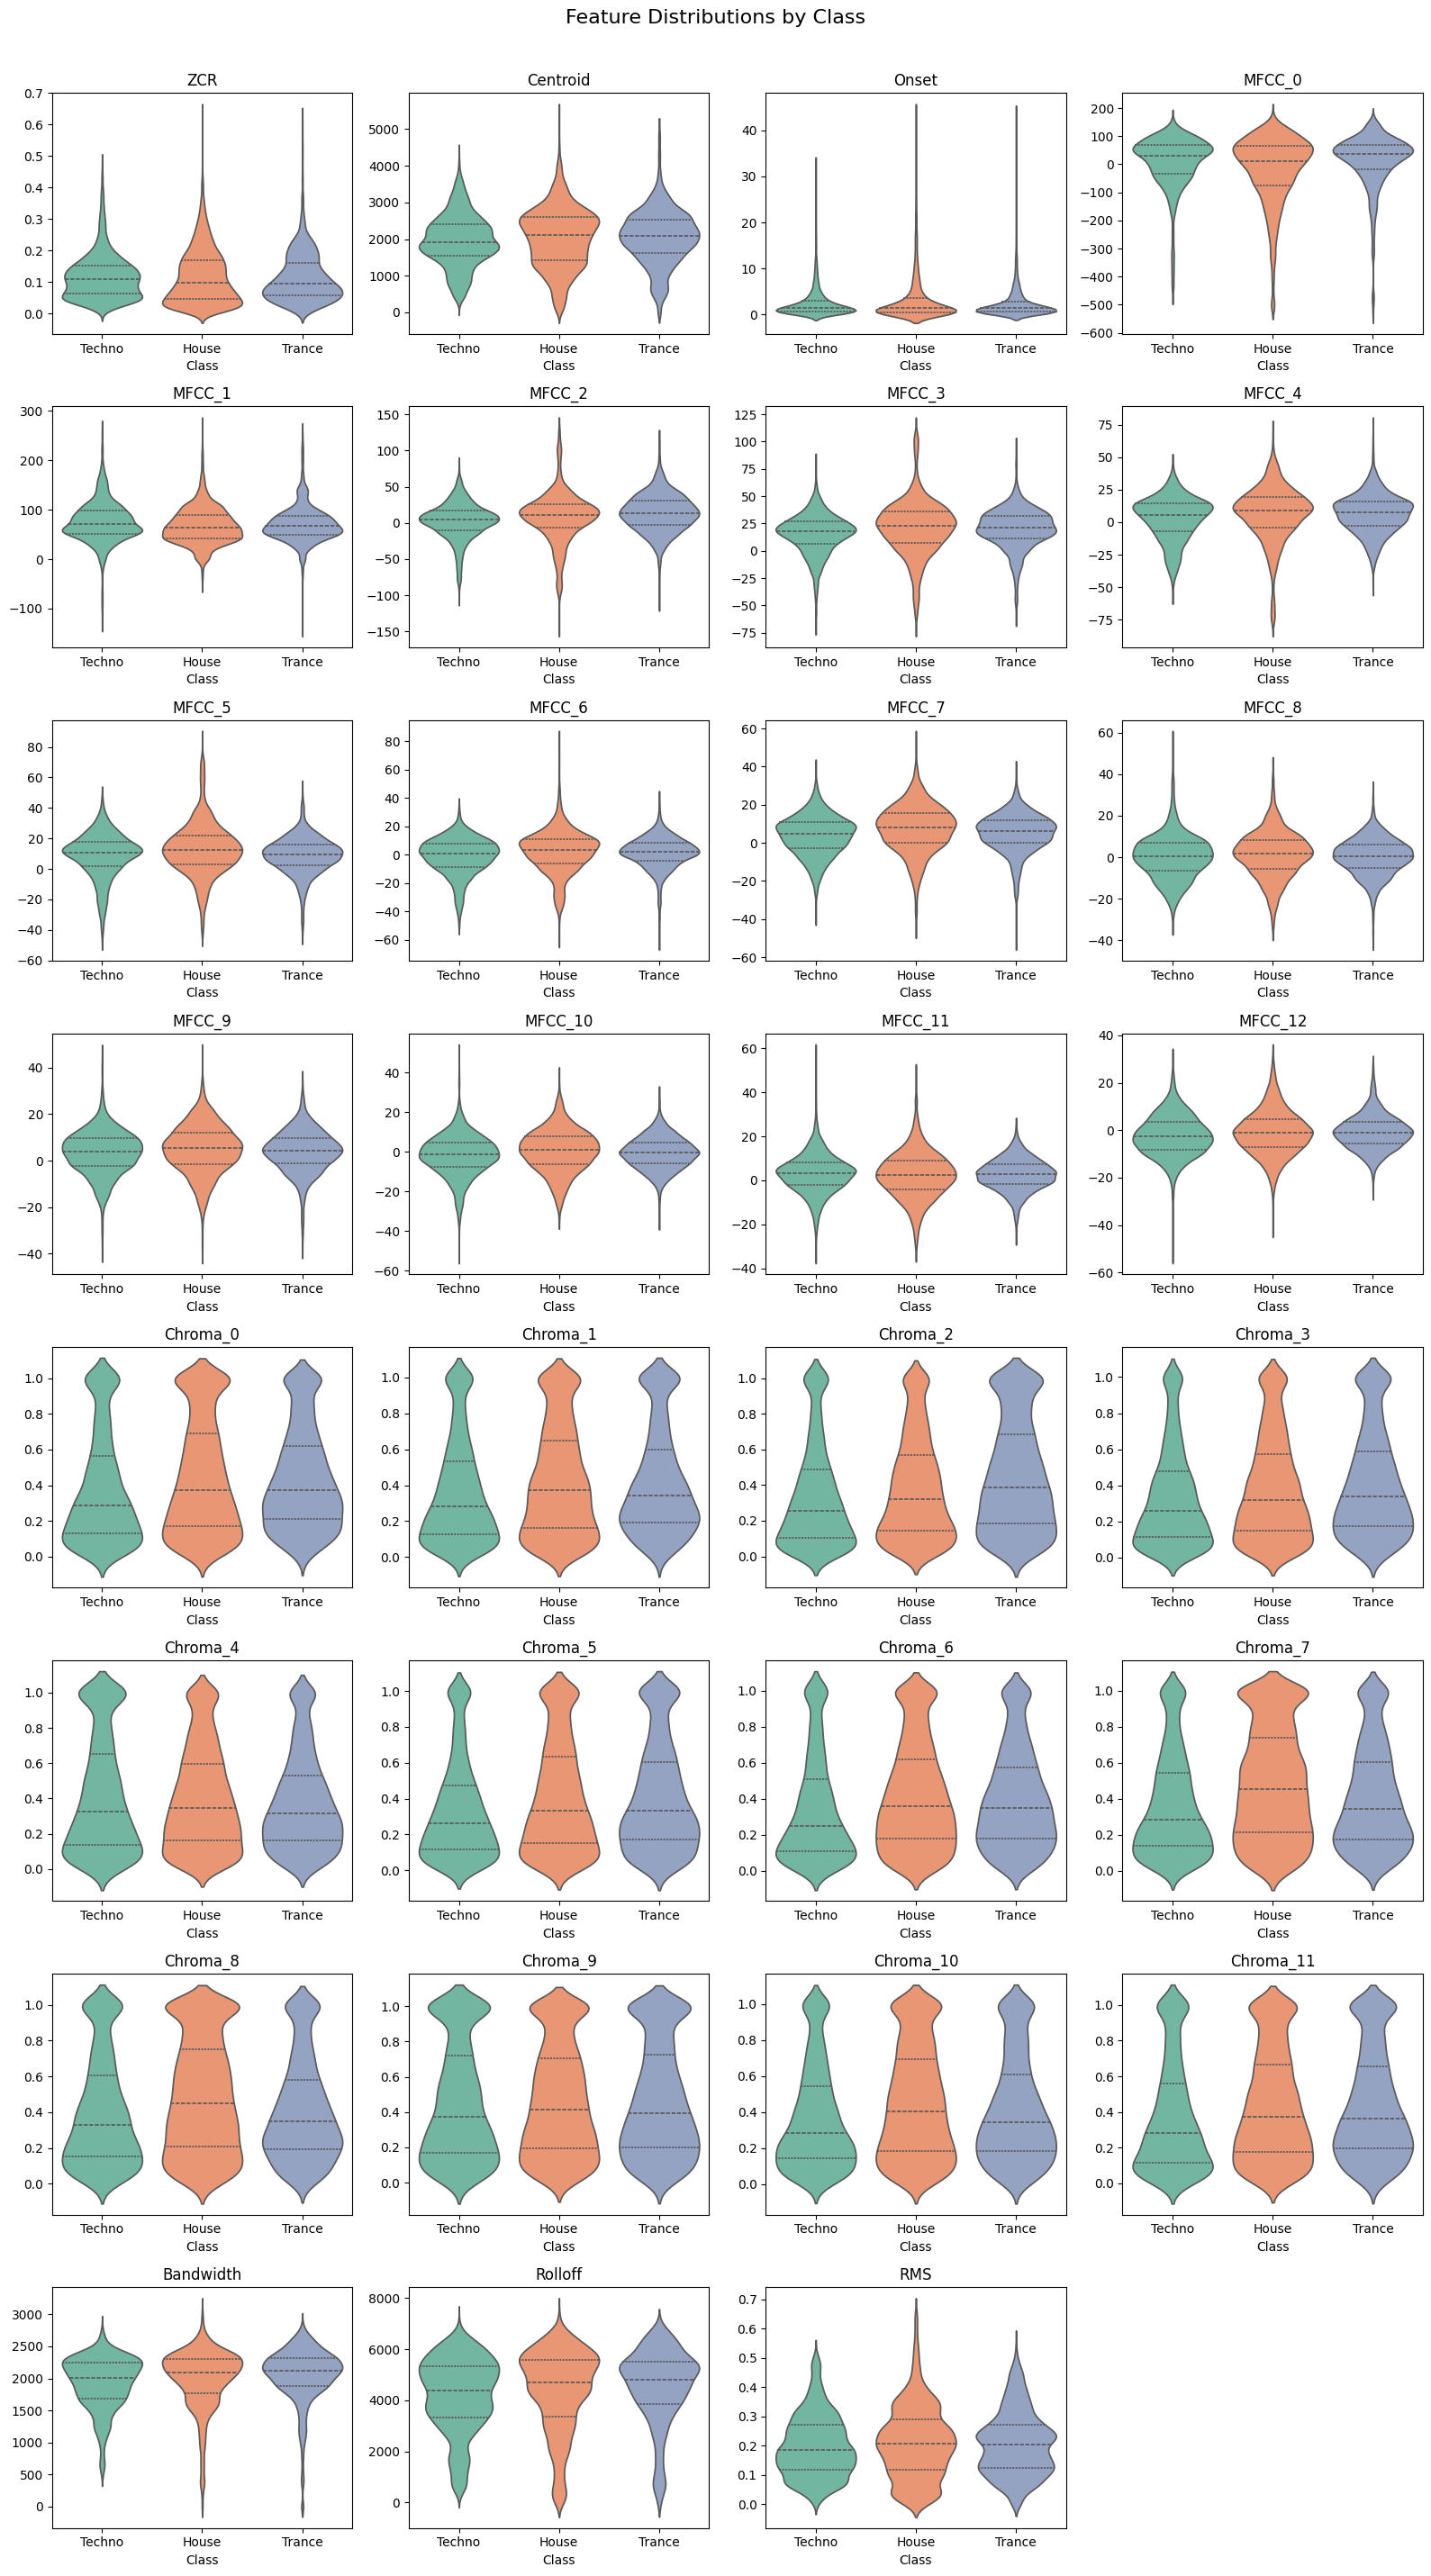

In [15]:
# Plot grid of violins
n_cols = 4
n_rows = int(np.ceil(len(features_names) / n_cols))
plt.figure(figsize=(4 * n_cols, 3.5 * n_rows))

for idx, col in enumerate(features_names):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.violinplot(data=df_features, x='label', y=col, hue='label', palette='Set2', inner='quartile', legend=False)
    plt.title(col)
    plt.xlabel("Class")
    plt.ylabel("")

plt.tight_layout()
plt.suptitle("Feature Distributions by Class", fontsize=16, y=1.02)
plt.show()

### Encode Labels

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_segments)  # 'house', 'techno', 'trance' → 0, 1, 2

## Aggregate data by temporal dimension

### Dimensionality Reduction

In [17]:
from utils import report_pca_variance
from utils_visual import plot_pca_2d, plot_pca_3d

In [18]:
# Compute segment-wise mean (across time axis)
X_frames_mean = X.mean(axis=1)
X_frames_mean.shape
# X_time_mean_scaled = RobustScaler().fit_transform(X_time_mean)

(194, 31)

### PCA plots for data aggregated across frames

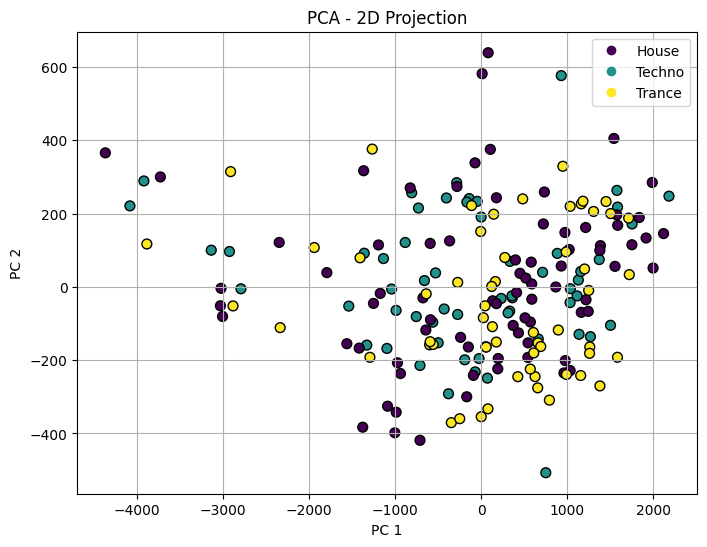

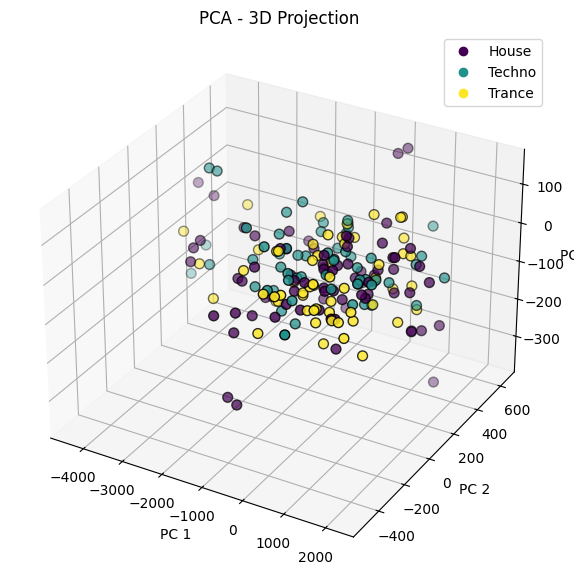

95% variance retained with 1 components.


In [19]:
X_pca2 = plot_pca_2d(X_frames_mean, y_encoded, class_names=le.classes_)
X_pca3 = plot_pca_3d(X_frames_mean, y_encoded, class_names=le.classes_)
n_component, cumvar = report_pca_variance(X_frames_mean, threshold=0.95)

In [20]:
# import warnings
# warnings.filterwarnings("ignore")
# np.seterr(divide='ignore', invalid='ignore')

### Train SVM

In [23]:
from utils import train_svm_pipelines

In [24]:
results = train_svm_pipelines(X_frames_mean, y_encoded)


=== MinMax Scaler ===
no_pca: F1-score = 0.608 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}
pca_2d: F1-score = 0.384 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.386 | Best Params = {'svc__C': 10, 'svc__gamma': 'auto'}
pca_95var: F1-score = 0.664 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}

=== Standard Scaler ===
no_pca: F1-score = 0.634 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}
pca_2d: F1-score = 0.309 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.391 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.691 | Best Params = {'svc__C': 10, 'svc__gamma': 'auto'}

=== Robust Scaler ===
no_pca: F1-score = 0.611 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}
pca_2d: F1-score = 0.386 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.360 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.664 | Best Params = {'svc__C': 10, '

## Aggregate data by spectral dimension

(194, 79)


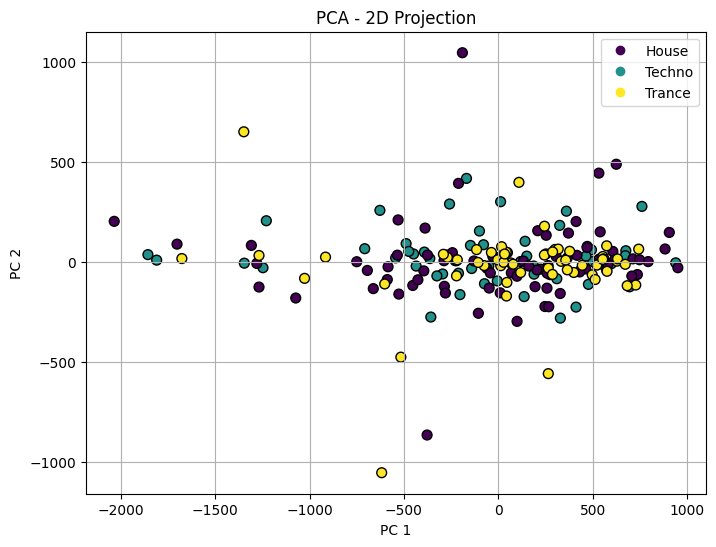

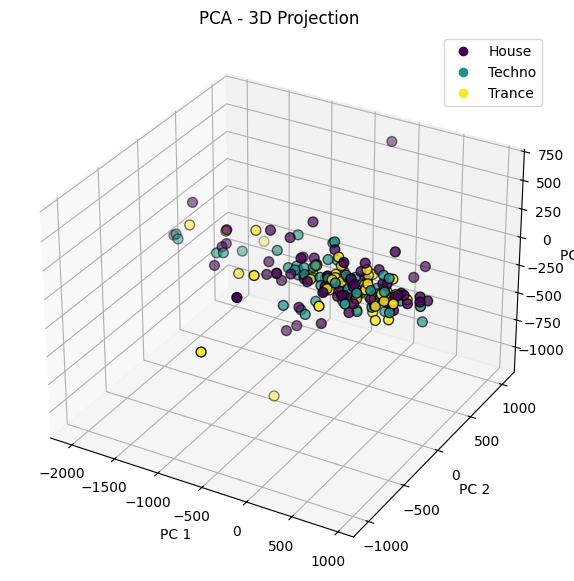

95% variance retained with 25 components.


In [25]:
X_freq_mean = X.mean(axis=2) # mean across frequency dimension
print(X_freq_mean.shape)

X_pca2 = plot_pca_2d(X_freq_mean, y_encoded, class_names=le.classes_)
X_pca3 = plot_pca_3d(X_freq_mean, y_encoded, class_names=le.classes_)
n_component, cumvar = report_pca_variance(X_freq_mean, threshold=0.95)

In [26]:
from utils import train_svm_pipelines

In [27]:
results = train_svm_pipelines(X_freq_mean, y_encoded)


=== MinMax Scaler ===
no_pca: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_2d: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}

=== Standard Scaler ===
no_pca: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_2d: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}

=== Robust Scaler ===
no_pca: F1-score = 0.350 | Best Params = {'svc__C': 1, 'svc__gamma': 'auto'}
pca_2d: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.239 | Best Params = {'svc__C': 0.1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.239 | Best Params = {'

## Flatten the two dimensions and treat those as features

In [28]:
X_flatten = X.reshape(-1, X.shape[1]*X.shape[2])  # flatten ninstances, frames*features
X_flatten.shape

(194, 2449)

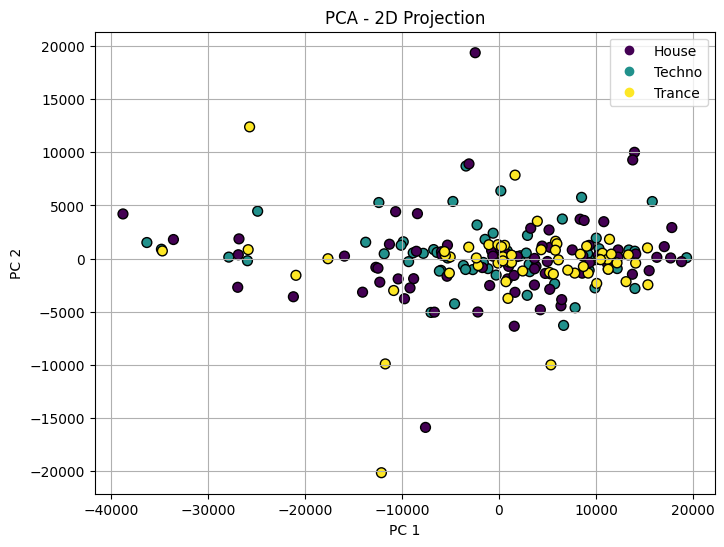

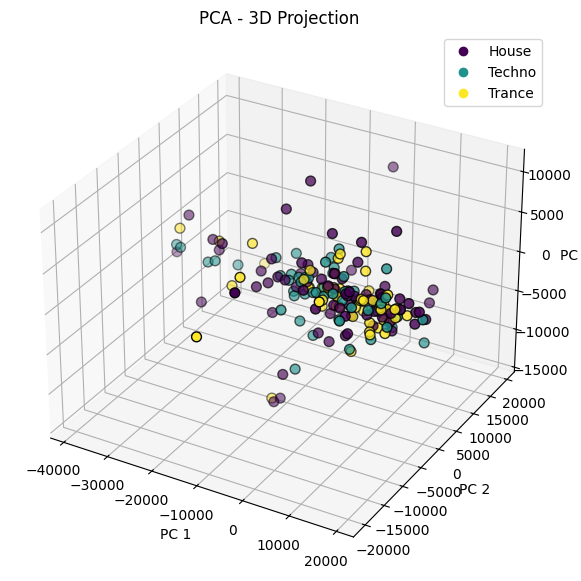

95% variance retained with 32 components.


In [29]:
X_pca2 = plot_pca_2d(X_flatten, y_encoded, class_names=le.classes_)
X_pca3 = plot_pca_3d(X_flatten, y_encoded, class_names=le.classes_)
n_component, cumvar = report_pca_variance(X_flatten, threshold=0.95)

## Training SVM

In [30]:
results = train_svm_pipelines(X_flatten, y_encoded)


=== MinMax Scaler ===
no_pca: F1-score = 0.383 | Best Params = {'svc__C': 10, 'svc__gamma': 'auto'}
pca_2d: F1-score = 0.382 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.437 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.450 | Best Params = {'svc__C': 1, 'svc__gamma': 'auto'}

=== Standard Scaler ===
no_pca: F1-score = 0.534 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}
pca_2d: F1-score = 0.407 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.461 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.502 | Best Params = {'svc__C': 10, 'svc__gamma': 'scale'}

=== Robust Scaler ===
no_pca: F1-score = 0.514 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_2d: F1-score = 0.411 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_3d: F1-score = 0.439 | Best Params = {'svc__C': 1, 'svc__gamma': 'scale'}
pca_95var: F1-score = 0.446 | Best Params = {'svc__C': 10, 'svc